In [1]:
!pip install catboost shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 27.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [3]:
df = pd.read_csv("https://stepik.org/media/attachments/lesson/779915/fs_task1_10f.csv")
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target
0,2015,163.000000,-1.450726,0.5,332,-0.018070,170,-9,0.10,50.339080,engine_ignition
1,2014,108.451384,2.233679,0.4,425,-0.849765,173,16,0.10,44.367816,break_bug
2,2010,167.738026,-8.024895,-0.8,50,0.134024,171,-9,0.10,44.902299,engine_check
3,2018,167.000000,-0.201363,2.0,224,-0.985060,173,-2,0.52,44.770115,engine_check
4,2019,183.000000,14.666233,0.8,351,0.606498,170,13,0.10,45.241379,another_bug


In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["target"] = le.fit_transform(df["target"])

## Линейная корреляция

<Axes: >

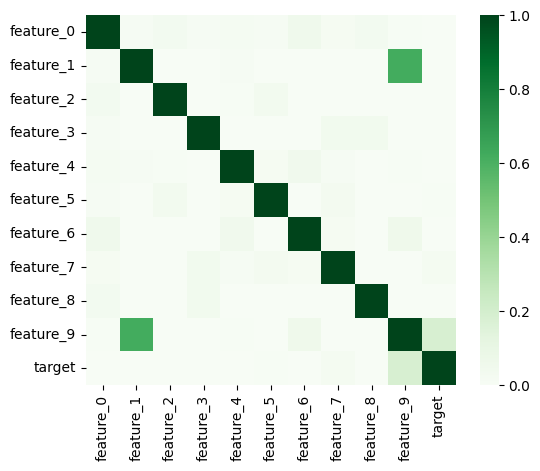

In [8]:
corrs = df.dropna().corr().round(3)
sns.heatmap(corrs,
            cmap = 'Greens',
            square=True,
            vmin = 0)

**Вывод:** Линейной зависимости нет НИ с кем

## Phik на стероидах

In [9]:
!pip install phik -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 9.3 MB/s eta 0:00:00


In [10]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'target']


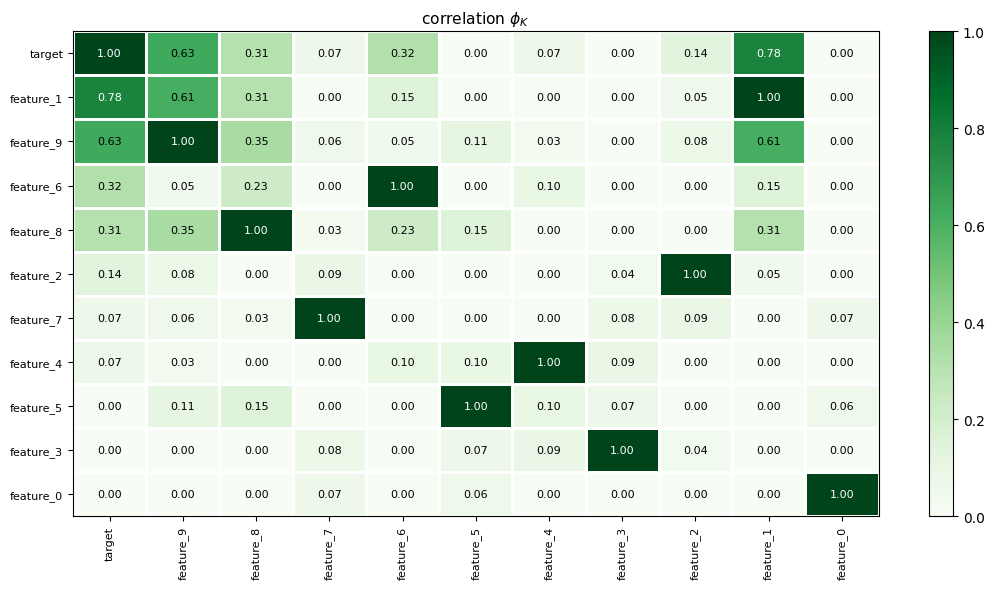

In [12]:
phik_overview = df.phik_matrix().round(2).sort_values('target')

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

answer_list = [1, 9, 8, 6, 2] # *Ответ верный*

## Feature importance

Берем koef важности призноков из рук модели;

In [13]:
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

In [14]:
drop_cols = ['target']

X = df.drop(drop_cols, axis=1, errors = 'ignore')
y = df['target'].fillna(0)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
model = CatBoostClassifier(random_state=42,
                           thread_count=-1)
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=100, plot=False,
          early_stopping_rounds=100)

Learning rate set to 0.10885
0:	learn: 1.9397215	test: 1.9473294	best: 1.9473294 (0)	total: 69.5ms	remaining: 1m 9s
100:	learn: 0.4678663	test: 0.6483020	best: 0.6483020 (100)	total: 1.27s	remaining: 11.3s
200:	learn: 0.3304501	test: 0.6373796	best: 0.6366906 (199)	total: 2.46s	remaining: 9.78s
300:	learn: 0.2467960	test: 0.6428317	best: 0.6361299 (254)	total: 3.65s	remaining: 8.49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6361299133
bestIteration = 254

Shrink model to first 255 iterations.


In [17]:
# посмотрим на важность признаков катбуста
fi = model.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,feature_1,32.490151
1,feature_9,29.112944
2,feature_8,12.172454
3,feature_2,4.631686
4,feature_6,4.100450
5,feature_7,3.807930
6,feature_5,3.795735
7,feature_4,3.491490
8,feature_3,3.473900
9,feature_0,2.923259


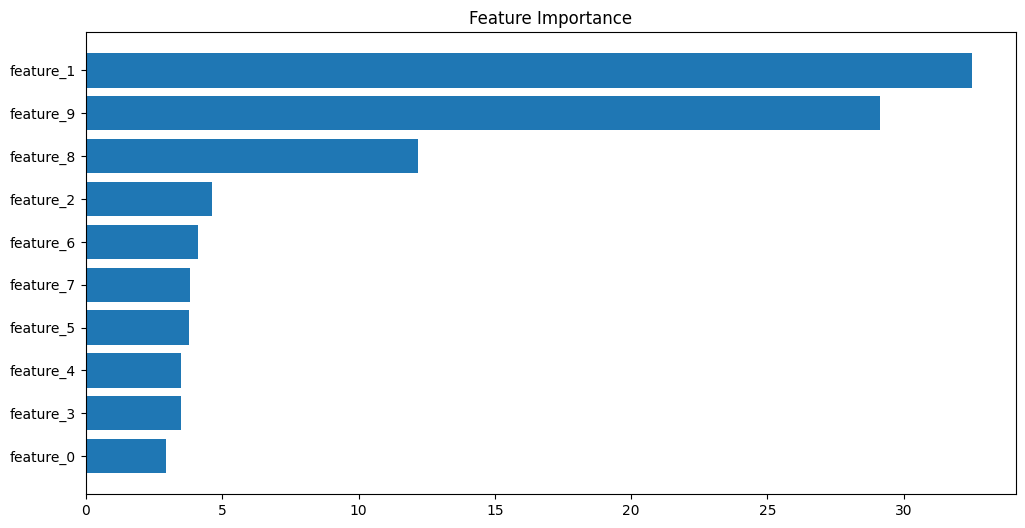

In [18]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

## Permutation importance

Перетасовываем значения одного столбца для проверки значимости

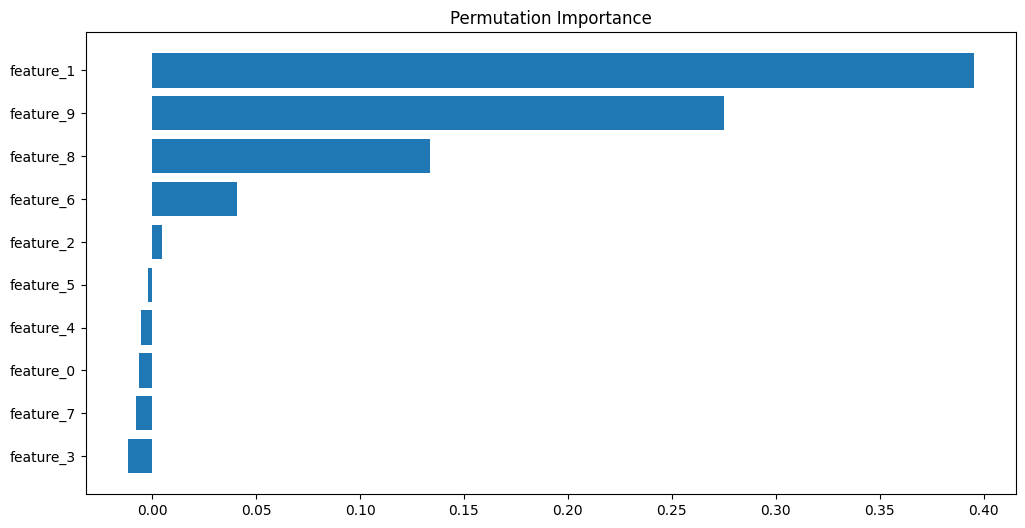

In [19]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

## SHAP values

Jснованные на теории игр, позволяют оценить важность признаков на конкретном тестовом примере: "модель + распределение данных"

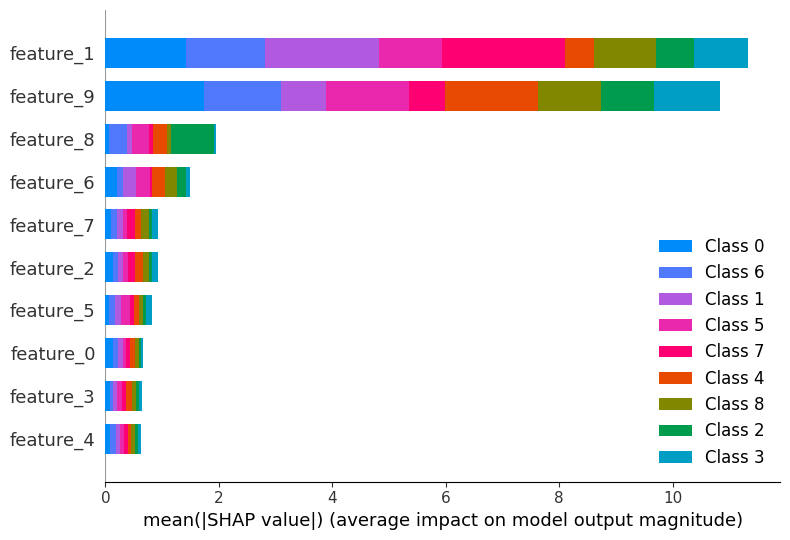

In [21]:
# Посмотрим на SHAP values
explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_test, label=y_test)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25)

## CatBoost feature selection (рекурсивные)

Суть рекурсивных алгоритмов: удаляем признаки и смотрим, уменьшится ли качество. Если уменьшилось, значит признак вредный

In [25]:
summary = model.select_features(X_train, y_train,
                      eval_set=(X_test, y_test),
                      features_for_select='0-9',
                      num_features_to_select=8,
                      steps=1,
                      train_final_model=False,
                      logging_level='Silent')

In [26]:
# Посмотрим на список отобранных фичей (не отранжирован по важности)
print(summary['selected_features_names'])
# И на лучшее значение лосса
print(f"Best loss: {summary['loss_graph']['loss_values'][-1]}")

['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
Best loss: 0.6193726400695475


In [27]:
# В summary сохраняется полный отчет работы алгоритма
summary

{'selected_features': [0, 1, 2, 3, 6, 7, 8, 9],
 'eliminated_features_names': ['feature_4', 'feature_5'],
 'loss_graph': {'main_indices': [0],
  'removed_features_count': [0, 1, 2],
  'loss_values': [0.6361299132602128, 0.6262806907485204, 0.6193726400695475]},
 'eliminated_features': [4, 5],
 'selected_features_names': ['feature_0',
  'feature_1',
  'feature_2',
  'feature_3',
  'feature_6',
  'feature_7',
  'feature_8',
  'feature_9']}

## Boruto

<div class="alert alert-info">    
    
Boruta метод отбора признаков пришедший из языка R. Хорошо работает только с алгоритмом RandomForest и достаточно долго вычисляется. <br>
Примерный принцип работы:
* создается копия всех признаков из исходного набора данных;
* случайным образом перемешиваются значения новых признаков - эти перемешанные дубли называются "теневыми" (shadow features)
* Далее N раз запускается обучение случайного леса, что дает возможность сгладить случайный шум при оценке важностей
* Потом по вычесленному порогу, часть признаков отсекается
* И начинается новый раунд с первого пункта (N раундов)
* В итоге исходные признаки попадают в 3 зоны - красную, синюю и зеленую
* Все признаки из красной зоны можно удалять, из синей сохраняем, зеленые самые сильные.

In [28]:
!pip install boruta -q

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.1 MB/s eta 0:00:00


In [29]:
###initialize Boruta
forest = RandomForestClassifier(
   n_jobs = -1,
   max_depth = 3
)
boruta = BorutaPy(
   estimator = forest,
   n_estimators = 'auto',
   max_iter = 8, # number of trials to perform
   verbose=1
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X_train), np.array(y_train))
### print results
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
red_area = X_train.columns[~(boruta.support_ | boruta.support_weak_)].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)
print('features in the red area:', red_area)

Iteration: 1 / 8
Iteration: 2 / 8
Iteration: 3 / 8
Iteration: 4 / 8
Iteration: 5 / 8
Iteration: 6 / 8
Iteration: 7 / 8


BorutaPy finished running.

Iteration: 	8 / 8
Confirmed: 	0
Tentative: 	5
Rejected: 	0
features in the green area: []
features in the blue area: ['feature_1', 'feature_2', 'feature_6', 'feature_8', 'feature_9']
features in the red area: ['feature_0', 'feature_3', 'feature_4', 'feature_5', 'feature_7']


## BoostARoota

BoostARoota, похож на Boruta, но использует в качестве базовой модели не случайный лес, а XGBoost.

In [31]:
!pip install boostaroota -q

from boostaroota import BoostARoota
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [32]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

br = BoostARoota(metric='logloss', silent=True)

#Fit the model for the subset of variables
br.fit(X_train, y_train_enc)

In [33]:
# Можно взглянуть на значения важности признаков
pd.DataFrame(br.keep_vars_)

,feature
0,feature_0
1,feature_1
2,feature_2
3,feature_3
4,feature_4
5,feature_5
6,feature_6
7,feature_7
8,feature_8
9,feature_9


## Проверим качество модели без лишних признаков

In [34]:
# Давайте возьмем топ-6 самых встречаемых и посмотрим как изменится точность.
important_features = ['feature_1', 'feature_8', 'feature_9', 'feature_6', 'feature_2']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(random_state=42,
                           thread_count=-1)


model.fit(X_train[important_features], y_train,
          eval_set=(X_test[important_features], y_test),
          verbose=100, plot=False,
          early_stopping_rounds=100)

Learning rate set to 0.10885
0:	learn: 1.8926515	test: 1.8796144	best: 1.8796144 (0)	total: 17ms	remaining: 17s
100:	learn: 0.5305167	test: 0.6123990	best: 0.6123990 (100)	total: 2.14s	remaining: 19.1s
200:	learn: 0.4353650	test: 0.5930203	best: 0.5909617 (176)	total: 4.05s	remaining: 16.1s
300:	learn: 0.3682699	test: 0.5886456	best: 0.5871819 (283)	total: 5.51s	remaining: 12.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5871819136
bestIteration = 283

Shrink model to first 284 iterations.


# Task_2

In [49]:
df = pd.read_csv(" https://stepik.org/media/attachments/lesson/779915/fs_task2_22f.csv")
lr = LabelEncoder()
df["target_class"] = lr.fit_transform(df["target_class"])
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target_reg,target_class
0,0,4.101552,173,1,3.405865,88182,157.168032,1.973071e+07,0,1,...,2015,191.996603,2020,0.1,0,174,9,4.76,57.15,5
1,0,4.303506,173,1,-2.218952,86897,121.805143,1.594185e+07,0,0,...,2015,193.547718,2015,0.1,1,174,7,4.26,60.82,5
2,0,4.246379,174,1,-3.740321,44604,175.889164,2.127630e+07,0,0,...,2013,177.922027,2019,0.1,1,174,6,5.98,46.51,5
3,0,4.342874,172,1,3.139031,114610,151.653445,2.250440e+07,0,0,...,2017,110.165268,2016,0.7,1,174,20,4.42,30.71,7
4,1,4.140287,148,0,-4.022916,114851,159.547387,1.163474e+07,0,0,...,2017,190.915943,2020,0.1,0,174,25,4.28,59.18,4


In [50]:
X = df.drop(['target_class', "target_reg"], axis=1, errors= "ignore")
y = df['target_class'].fillna(0)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

First_step -> **Phik**

Строите phik корреляцию и держите в голове, что рандомный признак не может сильно коррелировать ни с таргетом, ни с другими признаками.

interval columns not set, guessing: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'target_reg', 'target_class']


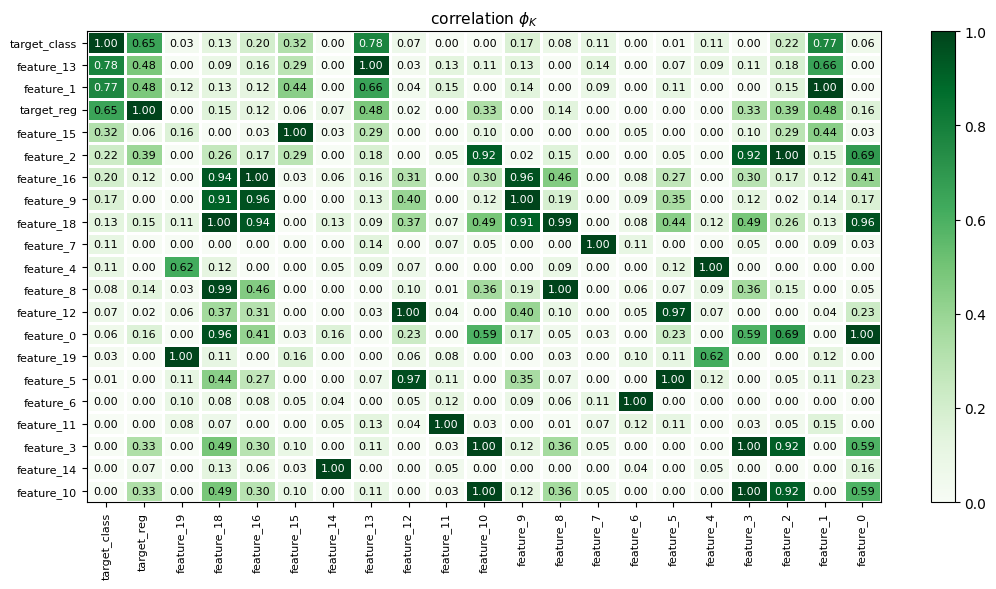

In [72]:
phik_overview = df.phik_matrix().round(2).sort_values('target_class')

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

In [ ]:
df["feature_11"].value_counts()

**Dision_tree**

In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

df = pd.read_csv('https://stepik.org/media/attachments/lesson/779915/fs_task2_22f.csv')


X = df.iloc[:, :20]

y = df['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

# Получение средних важностей
permutation_scores = perm_importance.importances_mean

# Оценка важности признаков с использованием permutation importance
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, permutation_scores))

# Сортировка признаков по их важности
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Вывод результатов
for feature, importance in sorted_feature_importance:
    print(f'{feature}: {importance:.4f}')

feature_1: 0.3406
feature_13: 0.3332
feature_15: 0.1218
feature_2: 0.0235
feature_16: 0.0095
feature_8: 0.0023
feature_17: 0.0000
feature_10: -0.0001
feature_0: -0.0003
feature_3: -0.0004
feature_9: -0.0062
feature_12: -0.0062
feature_14: -0.0078
feature_7: -0.0084
feature_18: -0.0087
feature_19: -0.0097
feature_6: -0.0097
feature_11: -0.0110
feature_5: -0.0133
feature_4: -0.0173


# Task_3

In [93]:
df = pd.read_csv("https://stepik.org/media/attachments/lesson/779915/fs_task3_310f.csv")

In [94]:
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])
X = df.drop(['target'], axis=1, errors='ignore')

y = df['target']

In [99]:
###initialize Boruta
forest = RandomForestClassifier(
   n_jobs = -1,
   max_depth = 5
)
boruta = BorutaPy(
   estimator = forest,
   n_estimators = 'auto',
   max_iter = 8, # number of trials to perform
   verbose=1
)
### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X_train), np.array(y_train))
### print results
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
red_area = X_train.columns[~(boruta.support_ | boruta.support_weak_)].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)
print('features in the red area:', red_area)

Iteration: 1 / 8
Iteration: 2 / 8
Iteration: 3 / 8
Iteration: 4 / 8
Iteration: 5 / 8
Iteration: 6 / 8
Iteration: 7 / 8


BorutaPy finished running.

Iteration: 	8 / 8
Confirmed: 	0
Tentative: 	5
Rejected: 	0
features in the green area: []
features in the blue area: ['feature_59', 'feature_141', 'feature_203', 'feature_234', 'feature_309']
features in the red area: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45'